# Machine Learning: Logistic Regression

## 0 Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

In [14]:
data = pd.read_csv("../dat/dips/DIPS_Data_cleaned.csv", sep = ",", low_memory = False)
data_pred = pd.read_csv("../dat/dips/DIPS_Data_cleaned_pred.csv", sep = ",", low_memory = False)
data_pred_y = pd.read_csv("../dat/dips/DIPS_Data_cleaned_pred_y.csv", sep = ",", low_memory = False)

## 1 Logistic Regression Model

In [15]:
# Predictors
X = data
X = X.drop(["hpi"], axis = 1)

# Target
y = data["hpi"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Logistic Regression \n",
      "X_train shape: ", X_train.shape, round(X_train.shape[0]/len(X), 2), "\n",
      "X_test shape: ", X_test.shape, round(X_test.shape[0]/len(X), 2),  "\n",
      "y_train shape: ", y_train.shape, round(y_train.shape[0]/len(y), 2), "\n",
      "y_test shape: ", y_test.shape, round(y_test.shape[0]/len(y), 2), "\n")

Logistic Regression 
 X_train shape:  (1005, 22) 0.8 
 X_test shape:  (252, 22) 0.2 
 y_train shape:  (1005,) 0.8 
 y_test shape:  (252,) 0.2 



In [16]:
def sklearn_log_regression(x_test_log, x_train_log, y_train_log, y_test_log):
    """Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights, testset predictions and metrics.
    """

    # linear regression model
    model = linear_model.LogisticRegression(fit_intercept = True, max_iter = 10000, penalty = None)

    # fitting it on the training data
    model.fit(x_train_log, y_train_log)

    # 1: ESTIMATING WEIGHTS
    weights_log = model.coef_
    features_log = model.feature_names_in_

    # 2: COMPUTE TEST SET PREDICTIONS
    y_pred_log = model.predict(x_test_log)

    # 3: COMPUTE METRICS
    accuracy_log = model.score(x_test_log, y_test_log)
    macro_f1_log = recall_score(y_test_log, y_pred_log, average = "macro")
    micro_f1_log = recall_score(y_test_log, y_pred_log, average = "micro")
    mcc_log = matthews_corrcoef(y_test_log, y_pred_log)

    # 4: COMPUTE CONFUSION MATRIX
    cm_log = confusion_matrix(y_test_log, y_pred_log)
    precision_log = cm_log[1][1] / (cm_log[1][1] + cm_log[0][1])
    recall_log = cm_log[1][1] / (cm_log[1][1] + cm_log[1][0])

    # store metrics in a dictionary
    metrics_log = {
        "accuracy": round(accuracy_log, 4),
        "macro_f1": round(macro_f1_log, 4),
        "micro_f1": round(micro_f1_log, 4),
        "mcc": round(mcc_log, 4),
        "precision": round(precision_log, 4),
        "recall": round(recall_log, 4),
        "confusion_matrix": cm_log
    }

    return weights_log, y_pred_log, features_log, metrics_log

In [17]:
def sklearn_log_lasso(x_test_l, x_train_l, y_train_l, y_test_l):
    """Computes OLS weights for linear regression with lasso regularization using the sklearn library on the training set and
       returns weights, testset predictions and metrics.
    """

    # 1: CROSS VALIDATION
    model_cv = linear_model.LogisticRegressionCV(fit_intercept = True, max_iter = 10000, penalty = "l1", solver = "saga", Cs = [0.001, 0.01, 0.1, 1, 10], cv = 5, scoring = "accuracy")

    model_cv.fit(x_train_l, y_train_l)

    best_c = model_cv.C_[0]
    print("Best C: ", best_c)

    model = linear_model.LogisticRegression(fit_intercept = True, max_iter = 10000, penalty = "l1", solver = "saga", C = best_c)

    model.fit(x_train_l, y_train_l)

    # 2: ESTIMATING WEIGHTS
    weights_l = model.coef_
    features_l = model.feature_names_in_

    # 3: COMPUTE TEST SET PREDICTIONS
    y_pred_l = model.predict(x_test_l)

    # 4: COMPUTE METRICS
    accuracy_l = model.score(x_test_l, y_test_l)
    macro_f1_l = recall_score(y_test_l, y_pred_l, average = "macro")
    micro_f1_l = recall_score(y_test_l, y_pred_l, average = "micro")
    mcc_l = matthews_corrcoef(y_test_l, y_pred_l)

    cm_l = confusion_matrix(y_test_l, y_pred_l)
    precision_l = cm_l[1][1] / (cm_l[1][1] + cm_l[0][1])
    recall_l = cm_l[1][1] / (cm_l[1][1] + cm_l[1][0])

    # store metrics in a dictionary
    metrics_l = {
        "accuracy": round(accuracy_l, 4),
        "macro_f1": round(macro_f1_l, 4),
        "micro_f1": round(micro_f1_l, 4),
        "mcc": round(mcc_l, 4),
        "precision": round(precision_l, 4),
        "recall": round(recall_l, 4),
        "confusion_matrix": cm_l
    }

    return weights_l, y_pred_l, features_l, metrics_l

In [18]:
weights_lr, y_pred_lr, features_lr, metrics_lr = sklearn_log_regression(X_test, X_train, y_train, y_test)
weights_lasso, y_pred_lasso, features_lasso, metrics_lasso = sklearn_log_lasso(X_test, X_train, y_train, y_test)

# save weights and predictions
weights_lr_df = pd.DataFrame(weights_lr, columns = features_lr)
weights_lasso_df = pd.DataFrame(weights_lasso, columns = features_lasso)
y_pred_lr = pd.DataFrame(y_pred_lr, columns = ["y_pred"])
y_pred_lasso = pd.DataFrame(y_pred_lasso, columns = ["y_pred"])

weights_lr_df.to_csv("../exp/weights/weights_lr_unreg.csv", sep = ",", index = False)
weights_lasso_df.to_csv("../exp/weights/weights_lr_lasso.csv", sep = ",", index = False)
y_pred_lr.to_csv("../exp/predictions/y_pred_lr_unreg.csv", sep = ",", index = False)
y_pred_lasso.to_csv("../exp/predictions/y_pred_lr_lasso.csv", sep = ",", index = False)

Best C:  1.0


In [19]:
metrics_lr

{'accuracy': 0.7222,
 'macro_f1': 0.5841,
 'micro_f1': 0.7222,
 'mcc': np.float64(0.2844),
 'precision': np.float64(0.7619),
 'recall': np.float64(0.1975),
 'confusion_matrix': array([[166,   5],
        [ 65,  16]])}

In [20]:
metrics_lasso

{'accuracy': 0.7183,
 'macro_f1': 0.578,
 'micro_f1': 0.7183,
 'mcc': np.float64(0.2694),
 'precision': np.float64(0.75),
 'recall': np.float64(0.1852),
 'confusion_matrix': array([[166,   5],
        [ 66,  15]])}

In [21]:
# plot feature importance
def plot_feature_importance(weights, features, title):
    """Plot feature importance for linear regression model"""
    # get absolute value of weights
    weights = np.abs(weights)

    # create dataframe
    df = pd.DataFrame({"features": features, "weights": weights[0]})

    # sort by weights
    df = df.sort_values(by = "weights", ascending = False)

    # plot
    plt.figure(figsize = (10, 10))
    sns.barplot(x = "weights", y = "features", data = df)
    plt.title(title)
    plt.show()

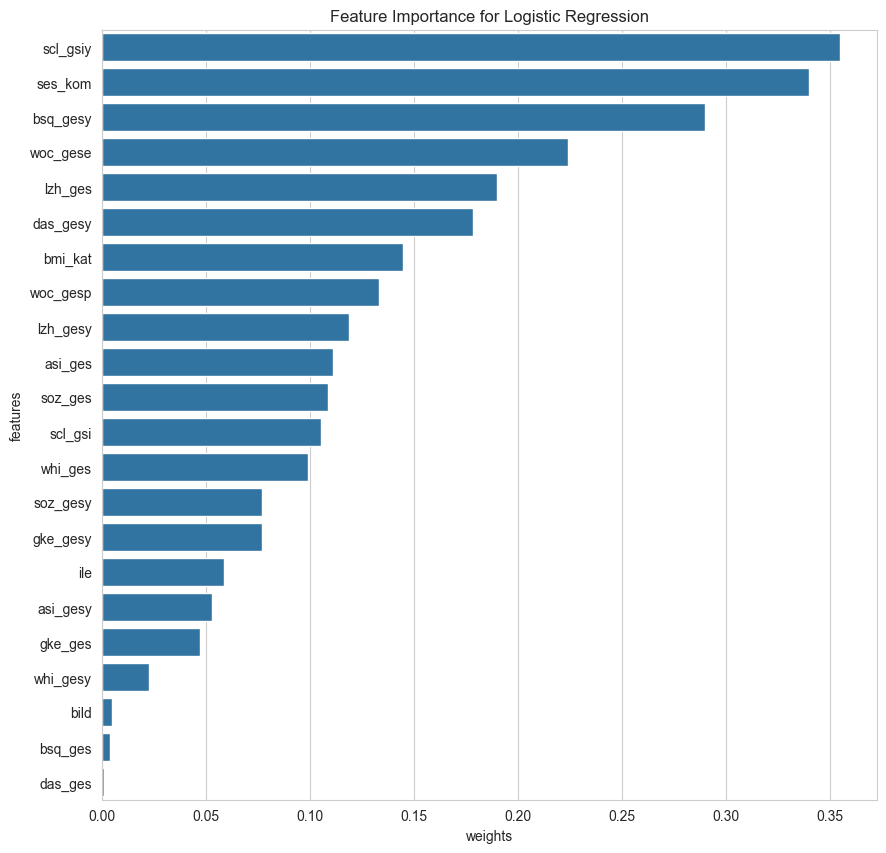

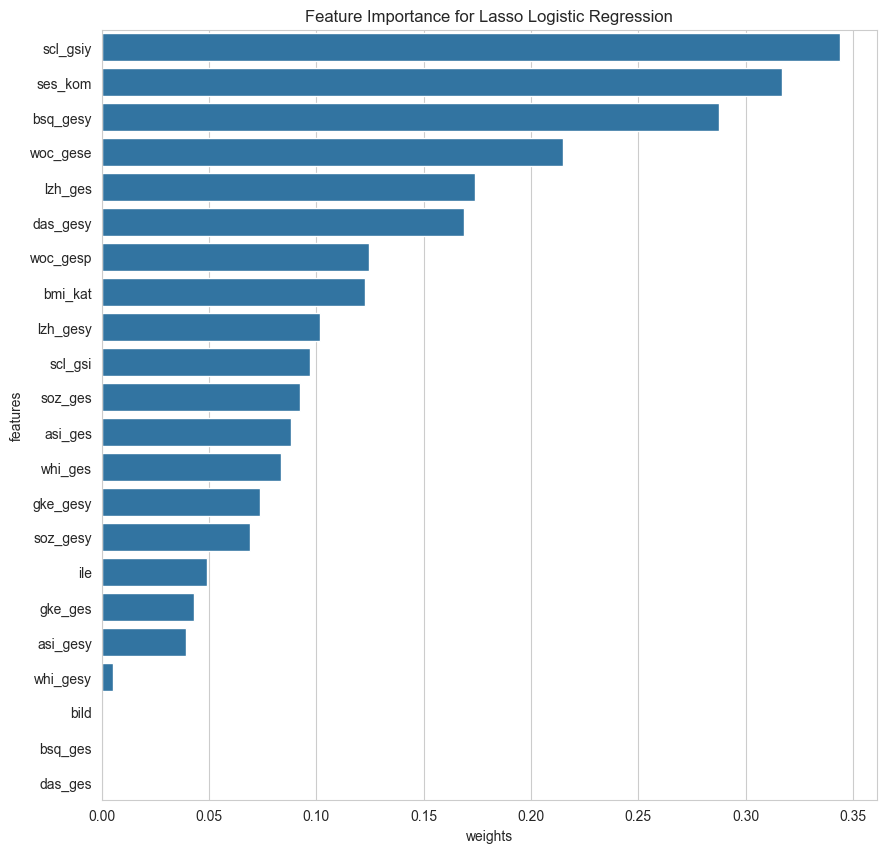

In [22]:
plot_feature_importance(weights_lr, features_lr, "Feature Importance for Logistic Regression")
plot_feature_importance(weights_lasso, features_lasso, "Feature Importance for Lasso Logistic Regression")

In [23]:
# plot feature importance in one plot
def plot_feature_importance_combined(weights_log, features_log, weights_l, features_l):
    """Plot feature importance for linear regression model"""
    # get absolute value of weights
    weights_log = np.abs(weights_log)
    weights_l = np.abs(weights_l)

    # create dataframe
    df_lr = pd.DataFrame({"features": features_log, "weights": weights_log[0], "model": "Logistic Regression"})
    df_lasso = pd.DataFrame({"features": features_l, "weights": weights_l[0], "model": "Lasso Logistic Regression"})

    # combine dataframes
    df = pd.concat([df_lr, df_lasso])

    # sort by weights
    df = df.sort_values(by = "weights", ascending = False)

    # plot
    plt.figure(figsize = (10, 10))
    sns.barplot(x = "weights", y = "features", hue = "model", data = df)
    plt.title("Feature Importance for Logistic Regression and Lasso Logistic Regression")
    plt.show()

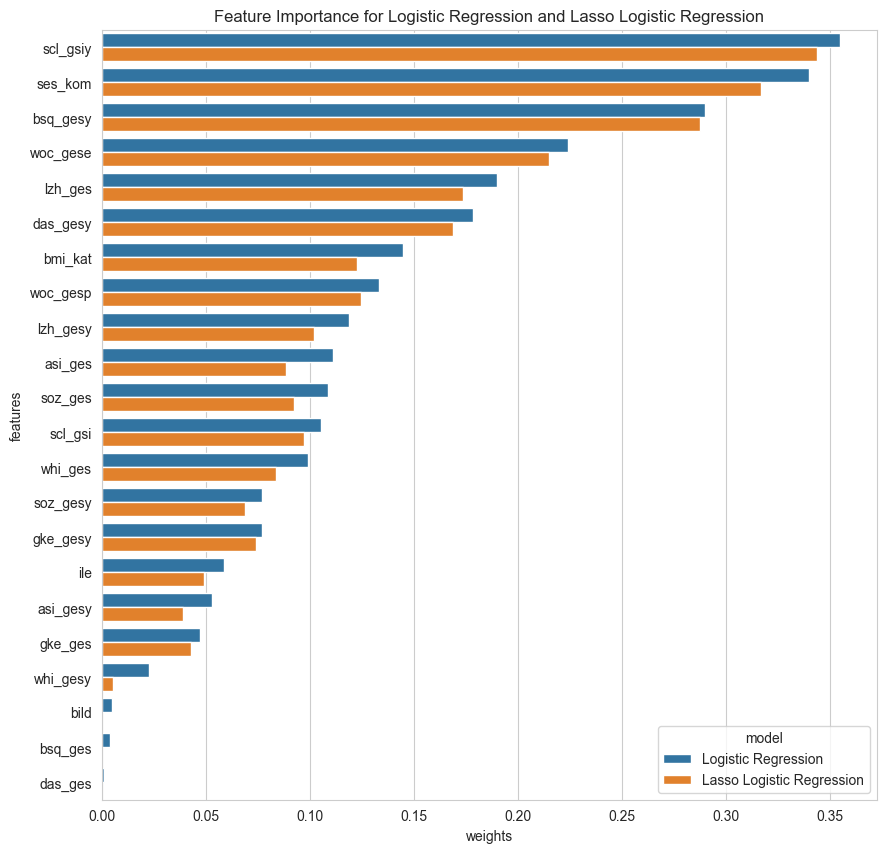

In [24]:
plot_feature_importance_combined(weights_lr, features_lr, weights_lasso, features_lasso)